In [1]:
library(foreign, quietly=T)
library(dplyr, quietly=T)
library(stringr, quietly=T
       )
library(foreach, quietly=T)
library(doParallel, quietly=T)
library(LaplacesDemon, quietly=T)
library(glmnet, quietly=T)
library(reshape, quietly=T)
library(ggplot2, quietly=T)
library(lubridate, quietly=T)
library(abind, quietly=T)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loaded glmnet 3.0-2



Attaching package: ‘reshape’


The following object is masked from ‘package:Matrix’:

    expand


The following object is masked from ‘package:dplyr’:

    rename



Attaching package: ‘lubridate’


The following object is masked from ‘package:reshape’:

    stamp


The following objects are masked from ‘package:LaplacesDemon’:

    dst, interval


The following objects are masked from ‘package:dplyr’:

    intersect, setdiff, union


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [2]:
source('../causal_inference_methods_code_corrupted.R')

In [3]:
variableExpander <- function(keysAndVariable, unitKey, timeKey){ ### Expands into unit/time format
  
  orderedData <- keysAndVariable %>% arrange(get(unitKey), get(timeKey))
  
  outcomeName <- names(keysAndVariable)[!(names(keysAndVariable) %in% c(unitKey, timeKey))]
  
  outcomeMatrixForm <- matrix(NA, nrow=length(unique(keysAndVariable[, unitKey])), 
                              ncol=length(unique(keysAndVariable[, timeKey])), byrow=T)
  
  rownames(outcomeMatrixForm) <- unique(keysAndVariable[, unitKey])
  
  colnames(outcomeMatrixForm) <- str_replace_all(unique(keysAndVariable[, timeKey])[order(unique(keysAndVariable[, timeKey]))], pattern="-", replace="")
  
  for (index in 1:length(keysAndVariable[, unitKey])){
    
    outcomeMatrixForm[keysAndVariable[, unitKey][index], str_replace_all(keysAndVariable[, timeKey][index], pattern="-", replace="")] <- keysAndVariable[, outcomeName][index]
    
  }
  
  return(outcomeMatrixForm)
  
}

In [4]:
indexMatrixMaker <- function(dim1, dim2, numRowsMissing=1, maxColsMissing){
    
    missingRows <- sample(1:dim1, size=numRowsMissing)
    
    howManyColsMissing <- min(c(rpois(length(missingRows), lambda=.15*dim2),
                              maxColsMissing))
    
    W <- matrix(0, nrow=dim1, ncol=dim2)
    
    for (num in 1:numRowsMissing){
       
        W[missingRows[num], (dim2-howManyColsMissing):dim2] <- 1
    
        
    }
    
    return(W)
    
}

In [5]:
smokingData <- read.csv("../../../California Smoking Data/smoking_data.csv",
                       row.names=1, stringsAsFactors=F)

smokingData <- smokingData %>% filter(year >= 1975 & year < 1998)

smokingData <- smokingData %>% 
mutate(lawPassed = as.numeric(state=="California" & year >= 1989))



In [6]:
length(table(smokingData$state))

[1] 39

In [7]:
partyData <- read.csv("../../../California Smoking Data/political_party_data.csv")

partyData <- partyData %>% mutate(propStateHouseDemocrats=stateHouseDemocrats/stateHouseTotal)

slimmedPartyData <- partyData %>% group_by(state, year) %>% summarize(stateHousePropDem=mean(stateHouseDemocrats/stateHouseTotal, na.rm=T),
                                                                     stateGovernorDemocrat=mean(democratGovernor, na.rm=T))

In [8]:
smokingData <- smokingData %>% dplyr::left_join(slimmedPartyData)

Joining, by = c("state", "year")

Warning message:
“Column `state` joining character vector and factor, coercing into character vector”


In [9]:
smokingData$stateHousePropDem[is.na(smokingData$stateHousePropDem)] <- 0
smokingData$stateGovernorDemocrat[is.na(smokingData$stateGovernorDemocrat)] <- 0

In [10]:
popData <- read.delim("../../../California Smoking Data/Population_Data_Annual.txt")

meltedPopData <- reshape2::melt(popData, id.vars='DATE')

names(meltedPopData) <- c("year", "abb", "population")

meltedPopData <- meltedPopData %>% mutate(year = year(ymd(year)), abb = str_replace(abb, "POP$", ""),
                                          population=population*1000)

In [11]:
nameAndAbbData <- cbind.data.frame(state.name, state.abb, state.area)
names(nameAndAbbData) <- c("name", "abb", "area")


# Outcome and Treatment Variable

In [12]:
cigSaleWide <- variableExpander(keysAndVariable=smokingData[c("state", "year", "cigsale")]
                                  , unitKey='state', timeKey="year")

lawPassedWide <- variableExpander(keysAndVariable=smokingData[c("state", "year", "lawPassed")]
                                  , unitKey='state', timeKey="year")

In [13]:
names(smokingData)

[1] "state"                 "year"                  "cigsale"              
 [4] "lnincome"              "beer"                  "age15to24"            
 [7] "retprice"              "lawPassed"             "stateHousePropDem"    
[10] "stateGovernorDemocrat"

# Other Covariates

In [14]:
### Can use: lnincome, retprice
covandTreatmentIndic <- smokingData %>% dplyr::select(state, year, lnincome, 
                                                     retprice, lawPassed)

#covandTreatmentIndic <- smokingData %>% dplyr::select(state, year, lnincome, stateHousePropDem, stateGovernorDemocrat,
#                                                     retprice, lawPassed)

In [15]:
mod <- glm(lawPassed~retprice+lnincome, data=covandTreatmentIndic , 
           family=binomial())

#mod <- glm(lawPassed~retprice+lnincome+stateHousePropDem
#           +stateGovernorDemocrat, data=covandTreatmentIndic , 
#           family=binomial())

In [16]:
summary(mod )


Call:
glm(formula = lawPassed ~ retprice + lnincome, family = binomial(), 
    data = covandTreatmentIndic)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.9348  -0.1179  -0.0344  -0.0128   3.2688  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)  
(Intercept) -48.08164   23.21262  -2.071   0.0383 *
retprice      0.04222    0.01652   2.556   0.0106 *
lnincome      3.68826    2.42824   1.519   0.1288  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 100.742  on 896  degrees of freedom
Residual deviance:  70.823  on 894  degrees of freedom
AIC: 76.823

Number of Fisher Scoring iterations: 9


In [17]:
covandTreatmentIndic$probPass <- mod$fitted.values

probPassEst <-
variableExpander(keysAndVariable=covandTreatmentIndic[c("state", "year", "probPass")]
                                  , unitKey='state', timeKey="year")
 

In [18]:
ourWeightMatrix <- propensity.score.to.weight(probPassEst, lawPassedWide)

# Running the Model

In [19]:
desired_clusters <- 30

max_available_clusters <- detectCores()

cl <- makeCluster(min(c(max_available_clusters, desired_clusters))-3)

registerDoParallel(cl)

In [20]:
completedSmokingInfo <- completion_with_rank_estimation_validate_mu(
    Y=cigSaleWide, W=lawPassedWide,  
    weight_matrix =ourWeightMatrix/sum(ourWeightMatrix),
                                                           initial_rank=40,
                                                           tolerance=1e-04, 
                                                           validation_max_iter=5000,
                                                           min_iter=100,
                                                           max_iter=10000,
                                                           mu_grid=10^seq(-3,3, 1),
                                                           K=5)

In [21]:
untreatedPotentialOutcomeMatrix = completedSmokingInfo$L_hat

In [22]:
smokingLawEffect = treat.estimator(Y=cigSaleWide, 
                                   L.hat=untreatedPotentialOutcomeMatrix,
               W=lawPassedWide)

In [23]:

boot_ests_r1Comp <- bootstrapCI(Y=cigSaleWide, W=lawPassedWide, 
                                method=completion_with_rank_estimation_validate_mu,
    ourWeightMatrix=ourWeightMatrix, bootstrap_samps=300,initial_rank=40,
  tolerance=1e-04, 
  validation_max_iter=500,
  min_iter=10,
  max_iter=1000,
  mu_grid=0,
  K=5 )

In [24]:
Cis_r1Comp <- apply(boot_ests_r1Comp, MARGIN=2, FUN=bs_percentile_method ,.95)


Cis_r1Comp

2.5%,-32.55069,-41.20617,-50.92043,-55.16429,-60.45054,-69.79962,-77.78981,-83.00443,-91.09025
97.5%,-19.02982,-25.62587,-38.14630,-40.61390,-47.75569,-57.77020,-63.52386,-62.96305,-63.88433


In [25]:
weightedSoftImputeInfo <- weightedSoftImpute_validate_lambda(Y=cigSaleWide, W=lawPassedWide,  
    weight_matrix =ourWeightMatrix, num_iter=1000, K=8, 
                                                             lambda_grid=seq(0, 2000, 100
                                                                    ), tolerance=1e-03)

smokingLawEffectWeightedSoftImpute <- treat.estimator(cigSaleWide, weightedSoftImputeInfo$L_hat, lawPassedWide)

In [26]:
untreatedPotentialOutcomeMatrix = weightedSoftImputeInfo$L_hat
longUntreatedPotentialOutcomes <- melt(untreatedPotentialOutcomeMatrix)
names(longUntreatedPotentialOutcomes) <- c("state", 'year', "cigsale")

In [27]:
weightedSoftImputeInfo$cv_lambda

[1] 100

In [28]:
#seq(0, 2000, 100)
boot_ests_weightedSoftImpute <- bootstrapCI(Y=cigSaleWide, W=lawPassedWide, 
    ourWeightMatrix=ourWeightMatrix, bootstrap_samps=300, 
    method=weightedSoftImpute_validate_lambda,num_iter=1000 ,
    K=5,
  lambda_grid=seq(0, 2000, 100),
  tolerance=1e-03)




In [29]:
bootEstData <- cbind.data.frame(1989:1997, colMeans(boot_ests_weightedSoftImpute))
colnames(bootEstData) <- c("Year", "Value")

In [30]:
Cis_weightedSoftImpute <- apply(boot_ests_weightedSoftImpute, MARGIN=2, FUN=bs_percentile_method ,.95)


names(Cis_weightedSoftImpute) <- 1989:1997


ciExample <- cbind.data.frame(1989:1997, t(Cis_weightedSoftImpute))
names(ciExample) <- c("Year", "Lower", "Upper")
                    
ciExamplePlot <- ggplot(ciExample, aes(x=factor(Year), y = Upper, group=1)) +
  geom_line(aes(y = Lower), linetype='dashed') + 
  geom_line(aes(y = Upper), linetype='dashed') + 
  geom_line(data=bootEstData, aes(x=factor(Year), y=Value), color='black', lwd=2)+
  geom_ribbon(aes(ymin = Lower, ymax = Upper), fill = "blue", alpha = .5) + 
  theme_bw(base_size=20)+ xlab("Year") + ylab("Difference in Cigarette Sales (per Capita)") + 
  ggtitle("Estimated Effect of Proposition 99,\nwith 95% Bootstrapped Cofidence Inervals")

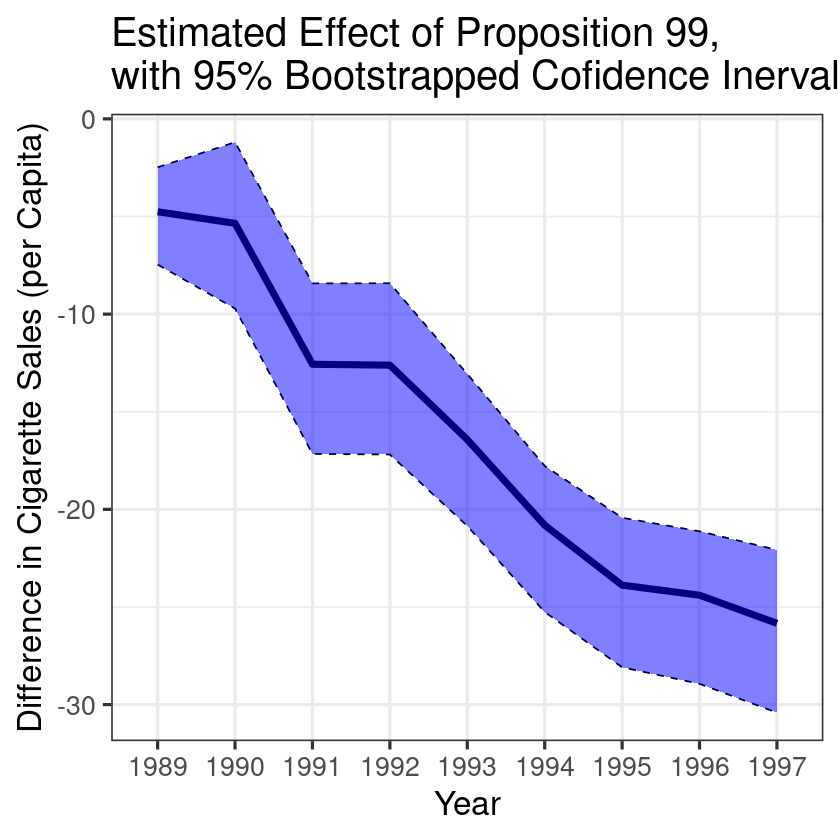

In [31]:
ciExamplePlot

In [32]:
untreatedOutcomesForPlotting <- smokingData

stateRegionDivision <- cbind.data.frame(state.name, state.region, state.division) 
names(stateRegionDivision) <- c("state", "Region", "Division")

untreatedOutcomesForPlotting <- untreatedOutcomesForPlotting %>% inner_join(stateRegionDivision)

finalPlottingData <- untreatedOutcomesForPlotting %>% group_by(Division, year) %>% 
summarize(averageSalesPerCapita=mean(cigsale, na.rm=T))

divisionComparisonPlot <- ggplot(finalPlottingData, aes(x=year, y=averageSalesPerCapita, color=Division))+
 geom_line() + theme_bw(base_size=20) + ylab("Average Sales (per Capita)") + 
ggtitle("Average Cigarette sales, by Division")

Joining, by = "state"

Warning message:
“Column `state` joining character vector and factor, coercing into character vector”


# Predicting Untreated Units

## Series of One Step Ahead Predictions


In [33]:
valYearStart = 1980

relevantCigSaleWide<- cigSaleWide[, as.numeric(dimnames(cigSaleWide)[[2]]) %in% 1975:1988]

validationData <- cigSaleWide[, as.numeric(dimnames(cigSaleWide)[[2]]) %in% valYearStart:1988]

meltedValidationData <- melt(validationData)

names(meltedValidationData) <- c("state", "year", "truth")

savedPredictions <- array(0, dim=c(dim(validationData), 4), dimnames=c(dimnames(validationData), list(c("MC-NNM", "weightedSoftImpute", "FACTOR", "ourMethod"))))


for (state in dimnames(relevantCigSaleWide)[[1]]){
    ### Remember, this is not comparable to the SDID results because you had
    ### to drop 1970-1974
    
    for (year in valYearStart:1988){
        
        cigSaleDataNow <- relevantCigSaleWide[, as.numeric(dimnames(relevantCigSaleWide)[[2]]) %in% 1975:year]
        
        theProbsEstNow <- probPassEst[, as.numeric(dimnames(probPassEst)[[2]]) %in% 1975:year]
        
        WThisStateAndYear <- array(0, dim=dim(cigSaleDataNow),
                                  dimnames=dimnames(cigSaleDataNow))
        
        WThisStateAndYear[state, as.character(year)] <- 1
        
        probsThisTime <- WThisStateAndYear*(1-theProbsEstNow)+theProbsEstNow
        
        weightsThisTime <- propensity.score.to.weight(probsThisTime, WThisStateAndYear)
        
        mc_nnm_info <- matrix_completion_causal(Y=cigSaleDataNow, W=WThisStateAndYear, num_iter=1000, K=4, 
                                        lambda_grid=c(10^seq(-4,2,1), seq(2,5,1)),
                                        tolerance=1e-04)
        
        weightedSoftImputeInfo <- weightedSoftImpute_validate_lambda(Y=cigSaleDataNow, W=WThisStateAndYear, 
                                                                     weight_matrix=weightsThisTime, num_iter=1000, K=5, 
                                                             lambda_grid=seq(0, 2000, 100), tolerance=1e-03)
        
        L_completionFactorModel <- completion_factor_model(Y=cigSaleDataNow, W=WThisStateAndYear, propScoreMat = probsThisTime,
                                                   numFactors=rankMatrix(mc_nnm_info$L_hat)[1])
        
        completedSmokingInfo <- completion_with_rank_estimation_validate_mu(
                                  Y=cigSaleDataNow, W=WThisStateAndYear , weight_matrix=weightsThisTime,
                                  initial_rank=40,
                                  tolerance=1e-04, 
                                  validation_max_iter=5000,
                                  min_iter=100,
                                  max_iter=10000,
                                  mu_grid=0,
                                  K=5)
        
        dimnames(mc_nnm_info$L_hat) <- dimnames(completedSmokingInfo$L_hat)
        dimnames(weightedSoftImputeInfo$L_hat) <- dimnames(completedSmokingInfo$L_hat)
        dimnames(L_completionFactorModel) <- dimnames(completedSmokingInfo$L_hat)
        
        savedPredictions[state, as.character(year),] <- c(mc_nnm_info$L_hat[state, as.character(year)], weightedSoftImputeInfo$L_hat[state, as.character(year)], 
                                                          L_completionFactorModel[state, as.character(year)], completedSmokingInfo$L_hat[state, as.character(year)])
        
    }
    
    
}


In [34]:
predictionDataFrame <- melt(savedPredictions)
names(predictionDataFrame) <- c("state", "year", "Method","prediction")
predictionDataFrame <- predictionDataFrame %>% inner_join(meltedValidationData)

Joining, by = c("state", "year")



In [35]:
unique(predictionDataFrame$state)

[1] Utah           Colorado       Kentucky       Vermont        Connecticut   
 [6] Alabama        South Carolina West Virginia  New Hampshire  Missouri      
[11] Oklahoma       Montana        Ohio           Maine          California    
[16] Pennsylvania   Mississippi    Arkansas       New Mexico     Wyoming       
[21] Texas          Delaware       Tennessee      Wisconsin      Iowa          
[26] Illinois       Nebraska       North Dakota   South Dakota   Indiana       
[31] Idaho          Rhode Island   Nevada         Kansas         Georgia       
[36] North Carolina Virginia       Louisiana      Minnesota     
39 Levels: Alabama Arkansas California Colorado Connecticut ... Wyoming

In [36]:
### Look at: Minnesota, Georgia, California
ohioCigSales <- ggplot(predictionDataFrame %>% filter(state=="Ohio"), aes(x=year, y=prediction, col=Method)) + 
geom_line() + geom_line(aes(x=year, y=truth), color='black') + theme_bw(base_size=20) + xlab("Year") + 
ylab("Predicted Sales (Cigarettes per Capita)") + 
ggtitle("One Step Ahead Predictions,\n for Ohio")

californiaCigSales <- ggplot(predictionDataFrame %>% filter(state=="California"), aes(x=year, y=prediction, col=Method)) + 
geom_line() + geom_line(aes(x=year, y=truth), color='black') + theme_bw(base_size=20) +
ylab("Predicted Sales (Cigarettes per Capita)") + xlab("Year") + 
ggtitle("One Step Ahead Predictions,\n for California")


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




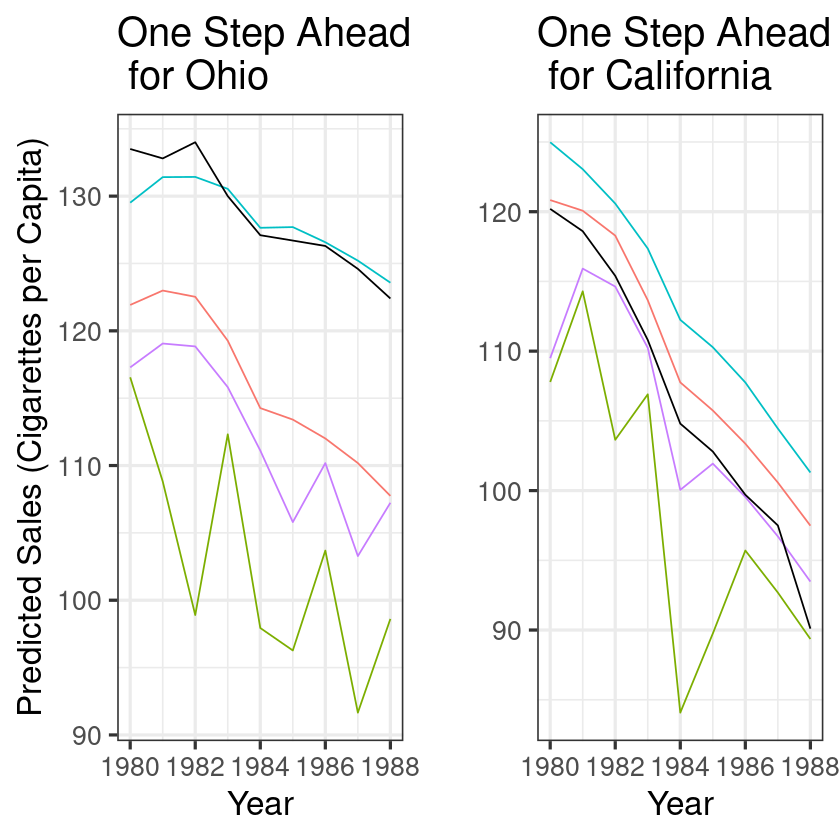

In [37]:
library(gridExtra)

cigSaleExampleGrid <- grid.arrange(ohioCigSales+ theme(legend.position = "none"), californiaCigSales + ylab("")+ theme(legend.position = "none"), ncol=2)

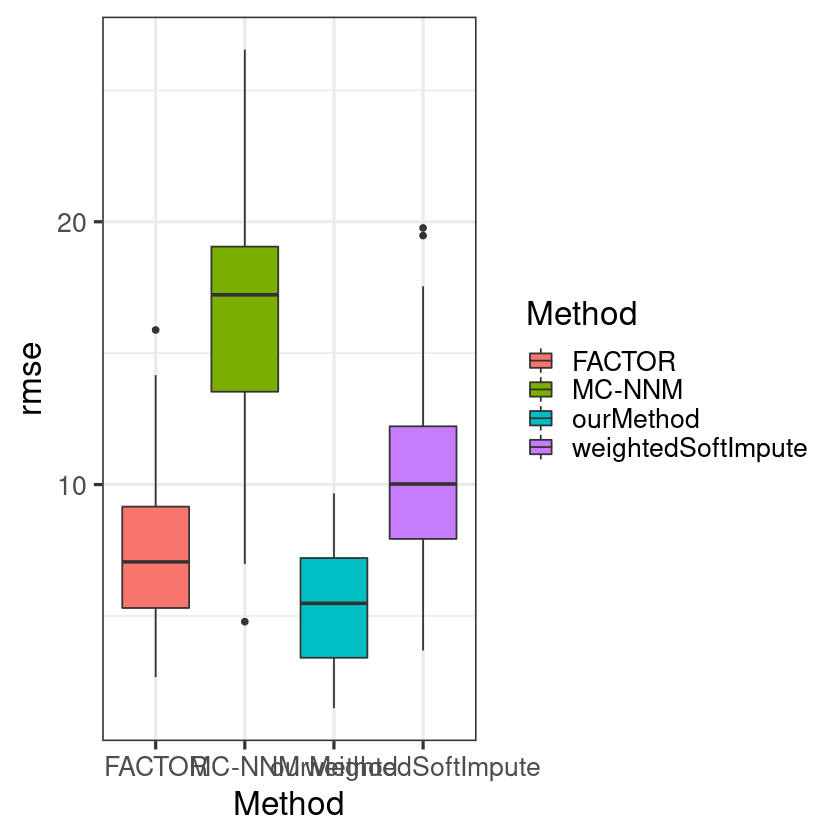

In [38]:
rmseByStateData <- predictionDataFrame %>% group_by(state, Method) %>% summarize(rmse = sqrt(mean((prediction-truth)^2)))

ggplot(rmseByStateData, aes(x=Method, y=rmse, fill=Method)) + geom_boxplot() + theme_bw(base_size=20)


In [39]:
oneStepAheadMSETable <- predictionDataFrame %>% group_by( Method) %>% 
 summarize(rmse = round(sqrt(mean((prediction-truth)^2)), 3))
names(oneStepAheadMSETable) <- c("Method", "RMSE")
oneStepAheadMSETable$Method <- factor(oneStepAheadMSETable$Method, 
    levels=as.character(oneStepAheadMSETable$Method)[c(2,4,1,3)])
oneStepAheadMSETable <- oneStepAheadMSETable[order(oneStepAheadMSETable$Method), ]
oneStepAheadMSETableLatexed <- knitr::kable(oneStepAheadMSETable, "latex")

In [40]:

oneStepAheadMSETable


Method,RMSE
<fct>,<dbl>
MC-NNM,17.271
weightedSoftImpute,11.095
FACTOR,8.184
ourMethod,5.712


In [41]:
#rmseByStateData  %>% group_by(state) %>% summarize(bestMethod = method[which.min(rmse)], min(rmse))
# Alabama, Ohio good ; California, 
#ggplot(predictionDataFrame %>% filter(state=="California"), aes(x=year, y=prediction, col=method)) + geom_line() +
#geom_line(aes(x=year, y=truth), color='black', lwd=2) + theme_bw(base_size=20)

### N Step Ahead Prediction

In [42]:
valYearStart = 1985

relevantCigSaleWide<- cigSaleWide[, as.numeric(dimnames(cigSaleWide)[[2]]) %in% 1975:1988]

trainingData <- cigSaleWide[, as.numeric(dimnames(cigSaleWide)[[2]]) %in% 1975:(valYearStart-1)]

validationData <- cigSaleWide[, as.numeric(dimnames(cigSaleWide)[[2]]) %in% valYearStart:1988]

meltedValidationData <- melt(validationData)

names(meltedValidationData) <- c("state", "year", "truth")

savedPredictions <- array(0, dim=c(dim(validationData), 4), dimnames=c(dimnames(validationData), 
                list(c("MC-NNM", "weightedSoftImpute", "FACTOR", "ourMethod"))))

theProbsEstNow <- probPassEst[, as.numeric(dimnames(probPassEst)[[2]]) %in% 1975:1988]

for (state in dimnames(relevantCigSaleWide)[[1]]){
    ### Remember, this is not comparable to the SDID results because you had
    ### to drop 1970-1974
        
        WThisStateAndYear <- array(0, dim=dim(relevantCigSaleWide),
                                  dimnames=dimnames(relevantCigSaleWide))
        
        WThisStateAndYear[state, dimnames(WThisStateAndYear)[[2]] %in% valYearStart:1988] <- 1
    
        neededParser <- dimnames(WThisStateAndYear)[[2]] %in% valYearStart:1988
        
        probsThisTime <- WThisStateAndYear*(1-theProbsEstNow)+theProbsEstNow
        
        weightsThisTime <- propensity.score.to.weight(probsThisTime, WThisStateAndYear)
        
        mc_nnm_info <- matrix_completion_causal(Y=relevantCigSaleWide, W=WThisStateAndYear, num_iter=1000, K=4, 
                                        lambda_grid=c(10^seq(-4,2,1), seq(2,5,1)),
                                        tolerance=1e-04)
        
        weightedSoftImputeInfo <- weightedSoftImpute_validate_lambda(Y=relevantCigSaleWide, W=WThisStateAndYear, weight_matrix=weightsThisTime, num_iter=1000, K=5, 
                                                             lambda_grid=seq(0, 2000, 10), tolerance=1e-03)
        
        L_completionFactorModel <- completion_factor_model(Y=relevantCigSaleWide, W=WThisStateAndYear, propScoreMat = probsThisTime,
                                                   numFactors=rankMatrix(mc_nnm_info$L_hat)[1])
        
        completedSmokingInfo <- completion_with_rank_estimation_validate_mu(
                                  Y=relevantCigSaleWide, W=WThisStateAndYear , weight_matrix=weightsThisTime,
                                  initial_rank=40,
                                  tolerance=1e-04, 
                                  validation_max_iter=5000,
                                  min_iter=100,
                                  max_iter=10000,
                                  mu_grid=0,
                                  K=5)
        
        dimnames(mc_nnm_info$L_hat) <- dimnames(completedSmokingInfo$L_hat)
        dimnames(weightedSoftImputeInfo$L_hat) <- dimnames(completedSmokingInfo$L_hat)
        dimnames(L_completionFactorModel) <- dimnames(completedSmokingInfo$L_hat)
        
        savedPredictions[state, ,] <- rbind(mc_nnm_info$L_hat[state, neededParser], weightedSoftImputeInfo$L_hat[state, neededParser], 
                                                          L_completionFactorModel[state, neededParser], completedSmokingInfo$L_hat[state, neededParser])
        
    
    
    
}

In [43]:
predictionDataFrame <- melt(savedPredictions)
names(predictionDataFrame) <- c("state", "year", "Method","prediction")
predictionDataFrame <- predictionDataFrame %>% inner_join(meltedValidationData)

Joining, by = c("state", "year")



In [44]:
NStepAheadMSETable <- predictionDataFrame %>% group_by( Method) %>% 
 summarize(rmse = sqrt(mean((prediction-truth)^2)))
names(NStepAheadMSETable) <- c("Method", "RMSE")
NStepAheadMSETable$Method <- factor(NStepAheadMSETable$Method, 
    levels=as.character(NStepAheadMSETable$Method)[c(2,4,1,3)])
NStepAheadMSETable <- NStepAheadMSETable[order(NStepAheadMSETable$Method), ]
NStepAheadMSETableLatexed <- knitr::kable(NStepAheadMSETable, "latex")

In [45]:


NStepAheadMSETable

Method,RMSE
<fct>,<dbl>
MC-NNM,16.77822
weightedSoftImpute,18.19816
FACTOR,19.48417
ourMethod,22.61386


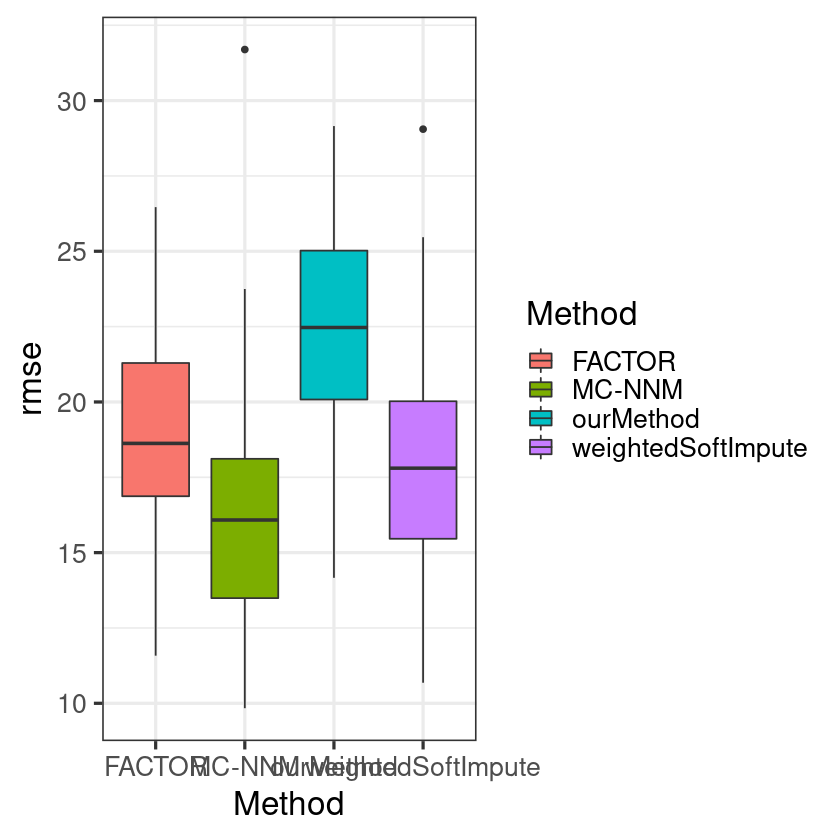

In [46]:
rmseByStateData <- predictionDataFrame %>% group_by(state, Method) %>% summarize(rmse = sqrt(mean((prediction-truth)^2)))

ggplot(rmseByStateData, aes(x=Method, y=rmse, fill=Method)) + geom_boxplot() + theme_bw(base_size=20)

In [47]:
nStepsAheadData <- rmseByStateData  %>% group_by(state) %>% 
summarize(bestMethod = Method[which.min(rmse)], min(rmse))

## Random Missingness

In [48]:
set.seed(48273)

missingUntreated <- matrix(0, nrow=dim(lawPassedWide)[1], 
                          ncol=dim(lawPassedWide)[2])

missingUntreated[
    sample(which(lawPassedWide == 0), .2*prod(dim(lawPassedWide)) )] <- 1

In [49]:
newW <- lawPassedWide+missingUntreated*(1-lawPassedWide)

In [50]:
adjustedProbs <- .2*(1-probPassEst)+probPassEst

In [51]:
adjustedWeightMatrix = propensity.score.to.weight(adjustedProbs, W=newW)

### MC-NNM

In [52]:
mc_nnm_info <- matrix_completion_causal(Y=cigSaleWide, W=newW, num_iter=1000, K=4, 
                                        lambda_grid=c(10^seq(-4,2,1), seq(2,5,1)),
                                        tolerance=1e-04)

L_mc_nnm <- mc_nnm_info$L_hat

In [53]:
missings <- as.numeric((cigSaleWide-mc_nnm_info$L_hat)*missingUntreated)

missings <- missings[missings != 0]

rmse_MCNNM <- sqrt(mean(missings^2))

### Weighted MC-NNM

In [54]:
weightedSoftImputeInfo <- weightedSoftImpute_validate_lambda(Y=cigSaleWide, W=newW, weight_matrix=adjustedWeightMatrix, num_iter=1000, K=5, 
                                                             lambda_grid=seq(0, 2000, 100), tolerance=1e-03)

In [55]:
missings <- as.numeric((cigSaleWide-weightedSoftImputeInfo$L_hat)*missingUntreated)

missings <- missings[missings != 0]

rmse_weightedSoftImpute <- sqrt(mean(missings^2))

### Factor Model

In [56]:
L_completionFactorModel <- completion_factor_model(Y=cigSaleWide, W=newW, propScoreMat = adjustedProbs,
                                                   numFactors=rankMatrix(mc_nnm_info$L_hat)[1])

In [57]:
missings <- as.numeric((cigSaleWide-L_completionFactorModel)*missingUntreated)

missings <- missings[missings != 0]

rmse_FACTOR <- sqrt(mean(missings^2))

### Our Method

In [58]:
completedSmokingInfo <- completion_with_rank_estimation_validate_mu(
    Y=cigSaleWide, W=newW, weight_matrix=adjustedWeightMatrix,
                            initial_rank=40,
                            tolerance=1e-04, 
                            validation_max_iter=5000,
                            min_iter=100,
                            max_iter=10000,
                            mu_grid=10^seq(-3,3, 1),
                            K=5)

In [59]:
missings <- as.numeric((cigSaleWide-completedSmokingInfo$L_hat)*missingUntreated)

missings <- missings[missings != 0]

rmse_ourMethod <- sqrt(mean(missings^2))

In [60]:
randomMissingResults <- array(cbind(c("MC-NNM", "Weighted softImpute", "FACTOR", "Our Method"),
    round(c(rmse_MCNNM, rmse_weightedSoftImpute, rmse_FACTOR, rmse_ourMethod), 3)),
                             dim=c(4,2))
dimnames(randomMissingResults)[[2]] <- c("Method", "RMSE")

In [61]:
randomMissingResults
randomMissingResultsLatex <- knitr::kable(randomMissingResults, "latex")

Method,RMSE
MC-NNM,4.944
Weighted softImpute,8.565
FACTOR,111.797
Our Method,6.276


In [62]:
outputDir <- "./smoking_data_plots_and_tables"
if (!dir.exists(outputDir)){
    
    dir.create(outputDir)
    
}





In [63]:
makeFilename <- function(directory, fileName){
    
    paste(directory, fileName, sep='/')
}

ggsave(makeFilename(outputDir, "division_comparison.pdf"), divisionComparisonPlot, width=11, height=8.5)
ggsave(makeFilename(outputDir, "cig_sale_one_step_ohio.pdf"), ohioCigSales, width=11, height=8.5)
ggsave(makeFilename(outputDir, "cig_sale_one_step_california.pdf"), californiaCigSales, width=11, height=8.5)
ggsave(makeFilename(outputDir, "combined_cig_sale_examples.pdf"), cigSaleExampleGrid, width=11, height=8.5)
ggsave(makeFilename(outputDir, "ci_example.pdf"), ciExamplePlot, width=11, height=8.5)


fileConn<-file(makeFilename(outputDir, "one_step_ahead_assessment.txt"))
writeLines(oneStepAheadMSETableLatexed, fileConn)
close(fileConn)

fileConn<-file(makeFilename(outputDir, "random_missing_assessment.txt"))
writeLines(randomMissingResultsLatex, fileConn)
close(fileConn)


In [64]:
# stopCluster(cl)